In [79]:
import torch as t
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
#conda install scikit-image
from skimage import color
from skimage.io import imshow
#conda install tqdm
from tqdm import tqdm_notebook
from torchvision import transforms
%matplotlib inline

(<matplotlib.image.AxesImage at 0xc9af2c8>, (256, 256, 3))

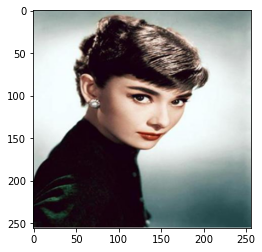

In [80]:
#彩色模式
img_rgb = Image.open("color.jpg").resize((256,256))
img_rgb = np.array(img_rgb)
plt.imshow(img_rgb),img_rgb.shape

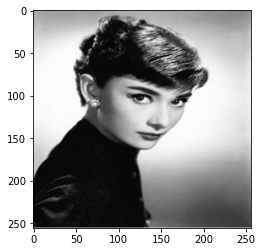

In [81]:
#黑白模式
img_gray = np.array(Image.open("color.jpg").convert('L').resize((256,256)))
plt.imshow(img_gray,cmap = 'gray')

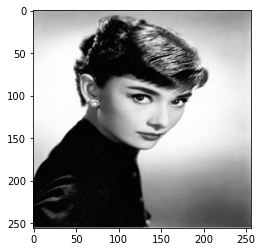

In [82]:
#常见图像模式为RBG，本代码例子采用lab模式，也有三个通道，第一个通道l是亮度通道，用来表示图片亮度，l通道效果与黑白图片相似
img_lab = color.rgb2lab(img_rgb/255)
img_lab_l = img_lab[:,:,0]
plt.imshow(img_lab_l,cmap = 'gray')

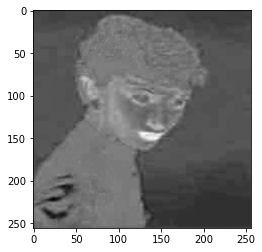

In [83]:
#a通道 隐藏了线条信息
img_lab_a = img_lab[:,:,1]
plt.imshow(img_lab_a,cmap = 'gray') 

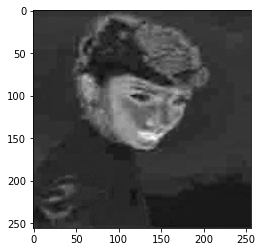

In [84]:
#b通道，隐藏了线条信息
img_lab_b = img_lab[:,:,2]
plt.imshow(img_lab_b,cmap = 'gray')

In [85]:
#上色原理：以亮度层为data，a层和b层为target，将亮度图像层（上面展示的黑白图片）和色彩层进行映射
#输入为l层，输出为a层和b层
class Net(t.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = t.nn.Sequential(
            t.nn.Conv2d(1,16,3,stride=2,padding=1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv2 = t.nn.Sequential(
            t.nn.Conv2d(16,32,3,2,1),
            t.nn.BatchNorm2d(32),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv3 = t.nn.Sequential(
            t.nn.Conv2d(32,16,3,2,1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv4 = t.nn.Sequential(
            t.nn.Conv2d(16,2,3,2,1),
            t.nn.BatchNorm2d(2),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [86]:
img_gray = img_gray[:,:,np.newaxis]
img_lab_l = img_lab_l[:,:,np.newaxis]
img_gray.shape,img_lab_l.shape

((256, 256, 1), (256, 256, 1))

In [87]:
x_train = img_lab_l


In [88]:
y_train = img_lab[:,:,1:3]
y_train /= 128

In [90]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [91]:
x_train,y_train = transform(x_train),transform(y_train)
x_train,y_train = x_train.float(),y_train.float()

In [92]:
x_train,y_train = x_train.view(-1,1,256,256),y_train.view(-1,2,256,256)


In [93]:
x_train.shape,y_train.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 2, 256, 256]))

In [94]:
#training model
net = Net()
net

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_

In [96]:
EPOCHS = 500
LR = 0.01
criterion = t.nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=LR,weight_decay=0.0)

In [97]:
from ipywidgets import IntProgress
for epoch in range(EPOCHS):
    index=0
    if epoch % 100 == 0:
        for param_group in optimizer.param_groups:
            LR = LR * 0.9
            param_group['lr'] = LR
    prediction = net.forward(x_train)
    loss = criterion(prediction,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
loss

tensor(0.0015, grad_fn=<MseLossBackward>)

In [98]:
net.eval()
prediction = net.forward(x_train)
prediction *= 128

In [99]:
prediction = prediction[0].data.numpy()
x_train = x_train[0].data.numpy()
x_train.shape,prediction.shape

((1, 256, 256), (2, 256, 256))

In [100]:
result = np.zeros((256,256,3))
result[:,:,0] = x_train[0]
result[:,:,1] = prediction[0]
result[:,:,2] = prediction[1]

In [101]:
result_rgb = color.lab2rgb(result)

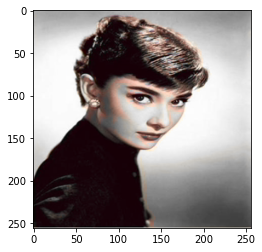

In [102]:
plt.imshow(np.array(result_rgb))